In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [3]:
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "darkgrey",
    "family": "arial",
}

label_font = {
    "fontsize": 10,
    "family": "arial",
}

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [67]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
TRAIN_DATASET_PATH = 'datasets/course_project_train.csv'
TEST_DATASET_PATH = 'datasets/course_project_test.csv'
PREPARED_TRAIN_DATASET_PATH = 'datasets/course_project_train_prepared.csv'
PREPARED_TEST_DATASET_PATH = 'datasets/course_project_test_prepared.csv'

TRAIN_FULL_PATH = 'datasets/course_project_train_full.csv'
TRAIN_PART_PATH = 'datasets/course_project_train_part.csv'
VALID_PART_PATH = 'datasets/course_project_valid_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'

#### Обзор обучающего датасета

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.shape

(7500, 17)

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Обзор тестового датасета

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.shape

df_test.head()

df_test.info()

df_test.isnull().sum()

### Обработка выбросов

**Обучающий датасет**

In [12]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


*Maximum Open Credit*

In [13]:
median_open_credit = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

In [14]:
median_loan_ammount = df_train['Current Loan Amount'].median()
df_train.loc[df_train['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

In [15]:
df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] / 10

**Тестовый датасет**

df_test.describe()

*Maximum Open Credit*

df_test.loc[df_test['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

df_test.loc[df_test['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] = df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] / 10

### Обработка пропусков обучающего датасета

##### Annual Income

median_income = {}
for value in df_train['Years in current job'].unique():
    median_income[value] = df_train.loc[df_train['Years in current job'] == value, 'Annual Income'].median()
    
median_income

In [16]:
for i in df_train.index[df_train['Annual Income'].isnull()]:
    monthly_debt = df_train.iloc[i, 14]
    df_train.iat[i, 1] = df_train.loc[(df_train['Monthly Debt'] < monthly_debt * 1.2) & (df_train['Monthly Debt'] > monthly_debt * 0.8), 'Monthly Debt'].median()

for i in df_train.index[df_train['Annual Income'].isnull()]:
    years = df_train.iloc[i, 2]
    df_train.iat[i, 1] = df_train.loc[(df_train['Years in current job'] == years)\
        & (~df_train['Years in current job'].isnull()), 'Annual Income'].median()

In [17]:
med_anual_income = df_train['Annual Income'].median()
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

##### Years in current job

In [18]:
job_years = df_train['Years in current job'].mode()[0]
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = job_years

##### Credit Score

In [19]:
credit_score = {}
for value in df_train['Years of Credit History'].unique():
    credit_score[value] = df_train.loc[df_train['Years of Credit History'] == value, 'Credit Score'].median()

In [20]:
for i in df_train.index[df_train['Credit Score'].isnull()]:
    cred_history_years = df_train.iloc[i, 5]
    df_train.iat[i, 15] = credit_score[cred_history_years]

In [21]:
median_credit_score = df_train['Credit Score'].median()
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = median_credit_score

 for i in df_train.index[df_train['Credit Score'].isnull()]:
    home_ownership = df_train.iloc[i, 0]
    df_train.iat[i, 15] = df_train.loc[(df_train['Home Ownership'] == home_ownership)\
        & (~df_train['Home Ownership'].isnull()), 'Credit Score'].median()

##### Bankruptcies

In [22]:
bankruptcies = {}
for value in df_train['Credit Score'].unique():
    bankruptcies[value] = df_train.loc[df_train['Credit Score'] == value, 'Bankruptcies'].median()

In [23]:
for i in df_train.index[df_train['Bankruptcies'].isnull()]:
    cred_score = df_train.iloc[i, 15]
    df_train.iat[i, 9] = bankruptcies[cred_score]

for i in df_train.index[df_train['Bankruptcies'].isnull()]:
    credit_score = df_train.iloc[i, 15]
    df_train.iat[i, 9] = df_train.loc[(df_train['Credit Score'] == credit_score)\
        & (~df_train['Credit Score'].isnull()), 'Bankruptcies'].median()

##### Months since last delinquent

Т.к. пропущенных значений больше половины, удаляю данный признак из датасета

In [24]:
df_train = df_train.drop(columns='Months since last delinquent')

delinquent_months = {}
for value in df_train['Bankruptcies'].unique():
    delinquent_months[value] = df_train.loc[df_train['Bankruptcies'] == value, 'Months since last delinquent'].median()

delinquent_months

for i in df_train.index[df_train['Months since last delinquent'].isnull()]:
    bankrupt = df_train.iloc[i, 9]
    df_train.iat[i, 8] = delinquent_months[bankrupt]

In [25]:
# for i in df_train.index[df_train['Months since last delinquent'].isnull()]:
#     bankruptcies = df_train.iloc[i, 9]
#     df_train.iat[i, 8] = df_train.loc[(df_train['Bankruptcies'] == bankruptcies)\
#         & (~df_train['Bankruptcies'].isnull()), 'Months since last delinquent'].median()

In [26]:
df_train.isnull().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

### Обработка пропусков тестового датасета

##### Annual Income

for i in df_test.index[df_test['Annual Income'].isnull()]:
    years = df_test.iloc[i, 2]
    df_test.iat[i, 1] = median_income[years]

for i in df_test.index[df_test['Annual Income'].isnull()]:
    years = df_test.iloc[i, 2]
    df_test.iat[i, 1] = df_train.loc[(df_train['Years in current job'] == years)\
        & (~df_train['Years in current job'].isnull()), 'Annual Income'].median()

df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

##### Years in current job

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = job_years

##### Credit Score

for i in df_test.index[df_test['Credit Score'].isnull()]:
    home_ownership = df_test.iloc[i, 0]
    df_test.iat[i, 15] = credit_score[home_ownership]

for i in df_test.index[df_test['Credit Score'].isnull()]:
home_ownership = df_test.iloc[i, 0]
 df_test.iat[i, 15] = df_train.loc[(df_train['Home Ownership'] == home_ownership)\
       & (~df_train['Home Ownership'].isnull()), 'Credit Score'].median()

##### Bankruptcies

for i in df_test.index[df_test['Bankruptcies'].isnull()]:
    cred_score = df_test.iloc[i, 15]
    df_test.iat[i, 9] = bankruptcies[cred_score]

for i in df_test.index[df_test['Bankruptcies'].isnull()]:
    credit_score = df_test.iloc[i, 15]
    df_test.iat[i, 9] = df_train.loc[(df_train['Credit Score'] == credit_score)\
        & (~df_train['Credit Score'].isnull()), 'Bankruptcies'].median()

##### Months since last delinquent

Т.к. пропущенных значений больше половины, удаляю данный признак из датасета

df_test = df_test.drop(columns='Months since last delinquent')

for i in df_test.index[df_test['Months since last delinquent'].isnull()]:
    bankrupt = df_test.iloc[i, 9]
    df_test.iat[i, 8] = delinquent_months[bankrupt]

 for i in df_test.index[df_test['Months since last delinquent'].isnull()]:
     bankruptcies = df_test.iloc[i, 9]
     df_test.iat[i, 8] = df_train.loc[(df_train['Bankruptcies'] == bankruptcies)\
         & (~df_train['Bankruptcies'].isnull()), 'Months since last delinquent'].median()

df_test.isnull().sum()

### Создаю дополнительные признаки

for purpose in df_train['Purpose'].unique():
    credit_default = df_train.loc[df_train['Purpose'] == purpose, 'Credit Default'].value_counts()
    print(credit_default, '\n\n')

df_train['Purpose'].unique()

**Is Loan Big - равен 1, если текущая сумма кредита больше медианного значения**

In [27]:
med_cur_ammount = df_train['Current Loan Amount'].median()
med_cur_ammount

309567.5

In [28]:
is_big_loan = [1 if el > med_cur_ammount else 0 for el in df_train['Current Loan Amount']]

In [29]:
df_train['Is Loan Big'] = is_big_loan

**Mean Home Ownership Income - средний доход домовладений по типам**

In [30]:
home_own_types = df_train['Home Ownership'].unique()
home_own_types

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [31]:
mean_home_own_income_by_type = [df_train.loc[df_train['Home Ownership'] == el, 'Annual Income'].mean() 
                                for el in home_own_types]
mean_home_own_income_by_type

[932477.1754250387, 1247308.2936486115, 937107.5639825219, 736345.5833333334]

In [32]:
df_mean_income = pd.DataFrame([home_own_types, mean_home_own_income_by_type], index=['Home Ownership', 'Mean Annual Income'])
df_mean_income = df_mean_income.T
df_mean_income

,Home Ownership,Mean Annual Income
0,Own Home,932477
1,Home Mortgage,1.24731e+06
2,Rent,937108
3,Have Mortgage,736346


In [33]:
mean_home_own_income_temp = [df_mean_income.loc[df_mean_income['Home Ownership'] == el, 'Mean Annual Income'].tolist() for el in df_train['Home Ownership']]
mean_home_own_income_temp[:5]

[[932477.1754250387],
 [932477.1754250387],
 [1247308.2936486115],
 [932477.1754250387],
 [937107.5639825219]]

In [34]:
mean_home_own_income = [el[0] for el in mean_home_own_income_temp]
mean_home_own_income[:5]

[932477.1754250387,
 932477.1754250387,
 1247308.2936486115,
 932477.1754250387,
 937107.5639825219]

In [35]:
df_train['Mean Home Ownership Income'] = mean_home_own_income

**Debt-to-income ratio**

In [36]:
df_train['Debt-to-income ratio'] = round((df_train['Monthly Debt'] * 12) / df_train['Annual Income'], 3)

### Is Payment High

In [37]:
is_payment_high = [1 if el > 0.43 else 0 for el in df_train['Debt-to-income ratio']]
is_payment_high[:5]

[0, 0, 0, 0, 0]

In [38]:
df_train['Is Payment High'] = is_payment_high

In [39]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,1,9.324772e+05,0.197,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,9.324772e+05,0.215,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,1,1.247308e+06,0.218,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,9.324772e+05,0.169,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,9.371076e+05,0.111,0


### Корреляционная матрица

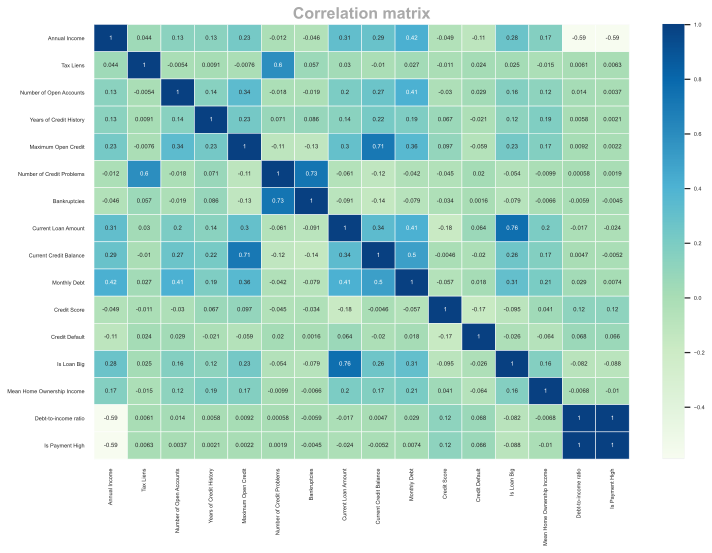

In [40]:
plt.figure(figsize = (12, 8))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix', fontdict=title_font)

plt.show()

### Заменяю пробелы в наименованиях признаков на нижние подчеркивания

NEW_NAMES = {'Home Ownership': 'Home_ownership', 'Annual Income': 'Annual_income', 
             'Years in current job': 'Years_in_current_job', 'Tax Liens': 'Tax_liens', 
            'Number of Open Accounts': 'Number_of_open_accounts', 'Years of Credit History': 'Years_of_credit_history',
            'Maximum Open Credit': 'Maximum_open_credit', 'Number of Credit Problems': 'Number_of_credit_problems',
            'Current Loan Amount': 'Current_loan_amount', 'Current Credit Balance': 'Current_credit_balance',
            'Monthly Debt': 'Monthly_debt', 'Credit Score': 'Credit_score', 'Credit Default': 'Credit_default'}

df_train.rename(columns=NEW_NAMES, inplace=True)
df_train.head()

### Обзор категориальных переменных

#### Обучающий датасет

In [41]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [42]:
df_train['Term Binary'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [43]:
df_train['Home Ownership digit'] = df_train['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

In [44]:
obj_columns = ['Years in current job', 'Purpose']

In [45]:
train_dummies = pd.get_dummies(df_train[obj_columns])
df_train = pd.concat([df_train, train_dummies], axis=1)

In [46]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High,Term Binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,1,9.324772e+05,0.197,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,9.324772e+05,0.215,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,1,1.247308e+06,0.218,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,9.324772e+05,0.169,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,9.371076e+05,0.111,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
df_train.shape

(7500, 48)

#### Тестовый датасет

for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

df_test['Term binary'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

df_test['Home Ownership digit'] = df_test['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

test_dummies = pd.get_dummies(df_test[obj_columns])
df_test = pd.concat([df_test, test_dummies], axis=1)

df_test['renewable_energy'] = 0

df_test.head()

df_test.info()

#### Сохраняю датасеты

In [48]:
df_train.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
#df_test.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

In [7]:
DATASET_PATH = 'datasets/course_project_train.csv'
PREP_DATASET_PATH = 'datasets/course_project_train_prepared.csv'

In [8]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High,Term Binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,1,9.324772e+05,0.197,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,9.324772e+05,0.215,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,1,1.247308e+06,0.218,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,9.324772e+05,0.169,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,9.371076e+05,0.111,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [51]:
df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(['Months since last delinquent', 'Credit Default']).tolist()
BASE_FEATURE_NAMES.append('Is Loan Big')
BASE_FEATURE_NAMES.append('Mean Home Ownership Income')
BASE_FEATURE_NAMES.append('Debt-to-income ratio')
BASE_FEATURE_NAMES.append('Is Payment High')
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

### Анализ целевой переменной

**Обзор распределения**

In [53]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

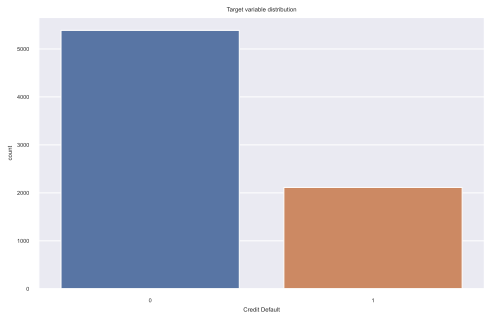

In [54]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

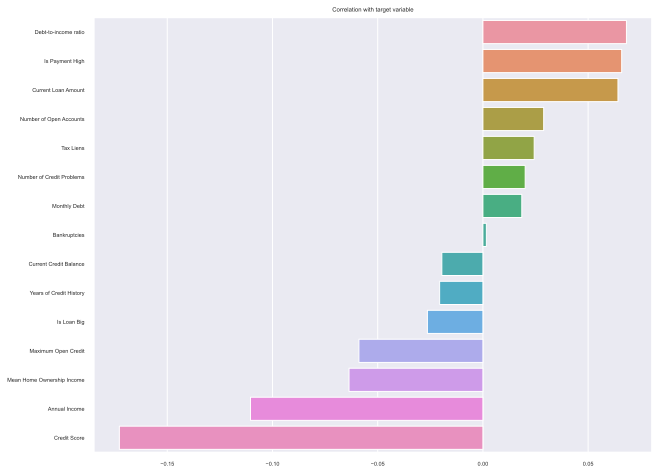

In [55]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

На основании этого графика, принял решение произвести оценку признаков с корреляцией более 0.05 по модулю.

**Оценка признака "Credit Score" в разрезе целевой переменной**

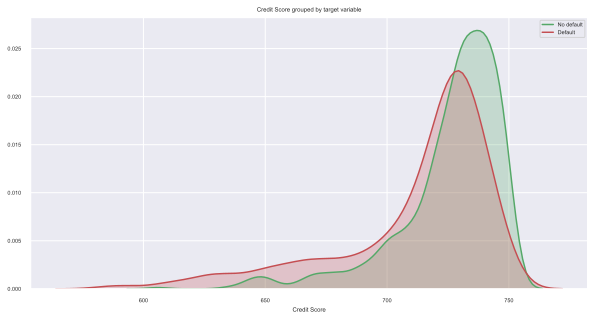

In [56]:
credit_score_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Credit Score" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [57]:
shapiro(credit_score_s)

ShapiroResult(statistic=0.8115907907485962, pvalue=1.3411827774961844e-32)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

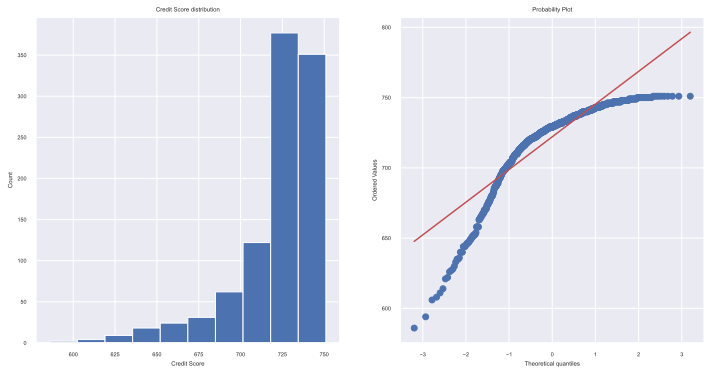

In [58]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_s.hist()

plt.subplot(122)
probplot(credit_score_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [59]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=73078.5, pvalue=7.914402325428086e-14)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

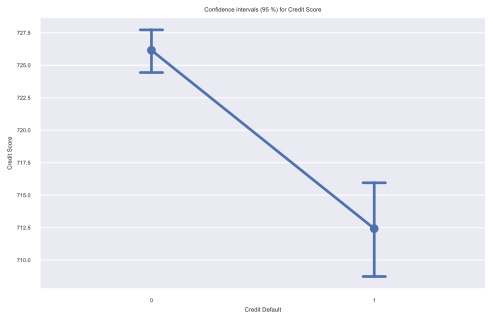

In [60]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

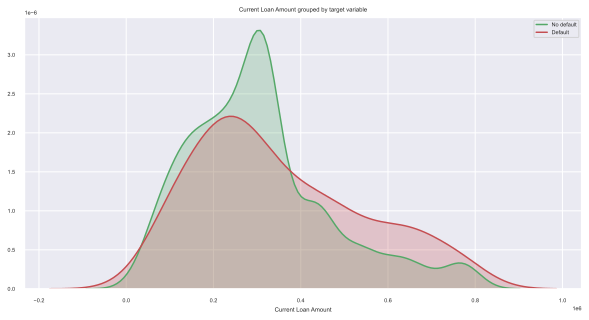

In [61]:
loan_amount_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
loan_amount_s = loan_amount_with_target_s['Current Loan Amount']
loan_amount_target_0 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 0]
loan_amount_target_1 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Current Loan Amount" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [62]:
shapiro(loan_amount_s)

ShapiroResult(statistic=0.9367077946662903, pvalue=3.4214933402146574e-20)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

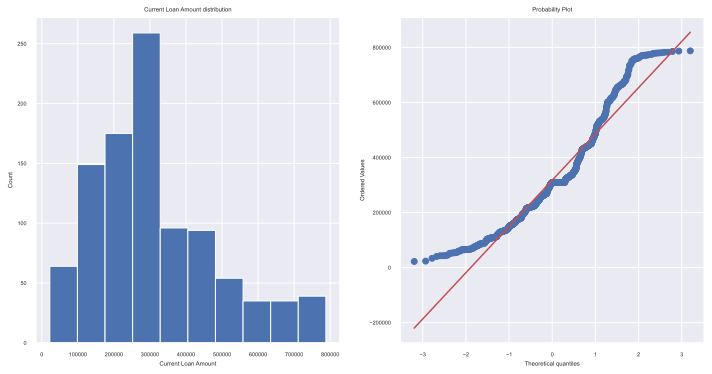

In [63]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
loan_amount_s.hist()

plt.subplot(122)
probplot(loan_amount_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [64]:
mannwhitneyu(loan_amount_target_0, loan_amount_target_1)

MannwhitneyuResult(statistic=87006.5, pvalue=0.001564289632628561)

Согласно значению p-value, гипотеза о равности мат. ожиданий подтверждается.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Annual Income" в разрезе целевой переменной**

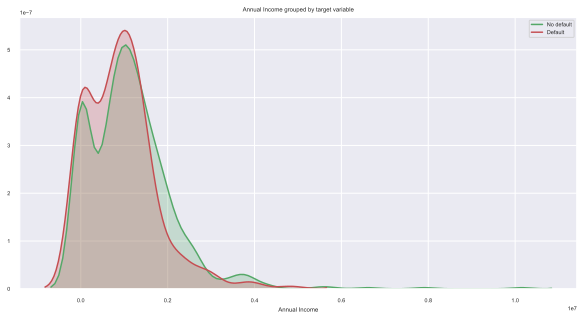

In [65]:
annual_income_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Annual Income" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [66]:
shapiro(annual_income_s)

ShapiroResult(statistic=0.84275221824646, pvalue=2.5178184334161006e-30)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

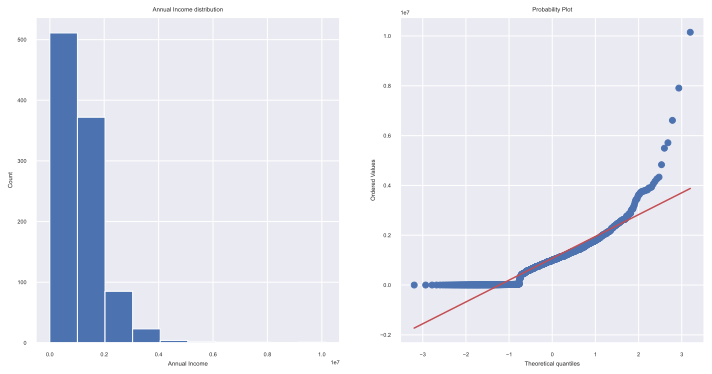

In [67]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [68]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=88073.0, pvalue=0.0009565645252728104)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

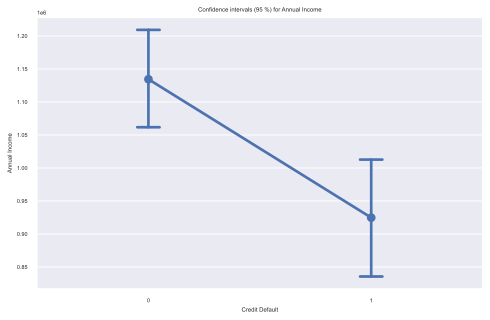

In [69]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

График показывает, что интервалы имеют незначительное пересечение. Однако степеньиз взаимного пересечения менее установлененого в гипотизе уровня значимости, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Maximum Open Credit" в разрезе целевой переменной**

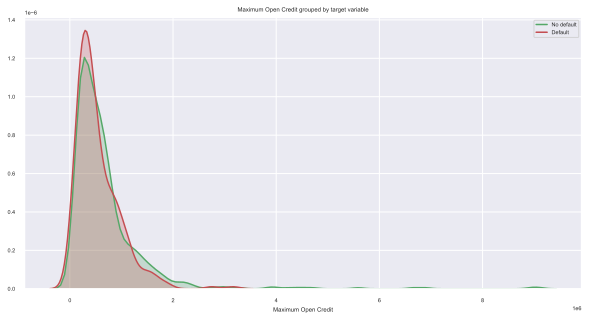

In [70]:
max_credit_with_target_s = df[['Maximum Open Credit', TARGET_NAME]].sample(1000)
max_credit_s = max_credit_with_target_s['Maximum Open Credit']
max_credit_target_0 = max_credit_s[max_credit_with_target_s[TARGET_NAME] == 0]
max_credit_target_1 = max_credit_s[max_credit_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(max_credit_target_0, shade=True, label='No default', color='g')
sns.kdeplot(max_credit_target_1, shade=True, label='Default', color='r')

plt.xlabel('Maximum Open Credit')
plt.title('Maximum Open Credit grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Maximum Open Credit" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [71]:
shapiro(max_credit_s)

ShapiroResult(statistic=0.573144793510437, pvalue=5.74532370373175e-44)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

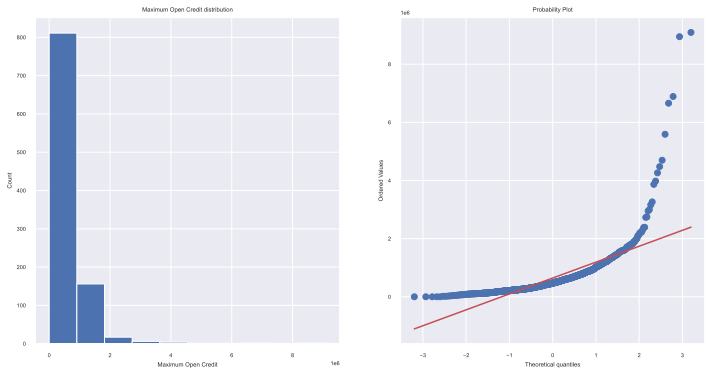

In [72]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Maximum Open Credit')
ax1.set_ylabel('Count')
ax1.set_title('Maximum Open Credit distribution')
max_credit_s.hist()

plt.subplot(122)
probplot(max_credit_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [73]:
mannwhitneyu(max_credit_target_0, max_credit_target_1)

MannwhitneyuResult(statistic=92962.0, pvalue=0.00909957663950003)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

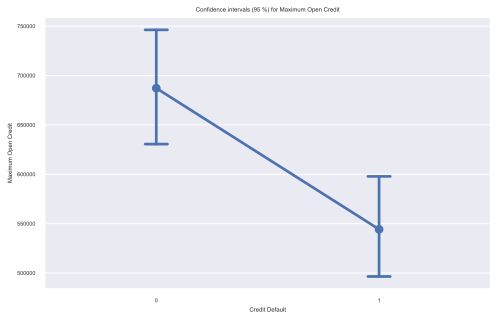

In [74]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=max_credit_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

**Матрица корреляций**

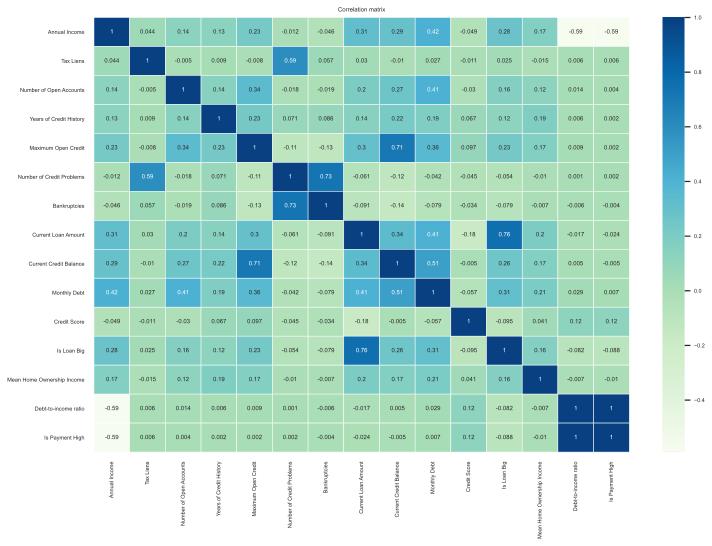

In [75]:
plt.figure(figsize = (12,8))

sns.set(font_scale=0.5)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [10]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
                     'Monthly Debt', 'Credit Score', 'Mean Home Ownership Income', 'Debt-to-income ratio']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

NEW_BINARY_FEATURES = ['Is Loan Big', 'Is Payment High']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_BINARY_FEATURES + NEW_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [11]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных

In [12]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High,Term Binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,-0.650243,10+ years,-0.110953,-0.026674,1.133645,0.063194,1.664779,2.545732,debt consolidation,Short Term,0.002830,-0.762772,-0.872085,1.077391,0,1,-0.989724,-0.505604,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,-0.065942,10+ years,-0.110953,0.788223,-0.428528,0.798425,-0.340979,-0.337099,debt consolidation,Long Term,-0.257436,0.330781,0.004909,0.604398,1,0,-0.989724,-0.501927,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,-0.360646,8 years,-0.110953,-0.026674,2.369181,0.799469,-0.340979,-0.337099,debt consolidation,Short Term,0.002830,0.058379,-0.391034,0.801478,0,1,1.029216,-0.501315,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,-0.302952,6 years,-0.110953,-0.637847,0.593985,-0.735496,1.664779,2.545732,debt consolidation,Short Term,-1.095166,-0.610282,-0.584980,-1.090493,0,0,-0.989724,-0.511323,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,-0.333924,8 years,-0.110953,0.380774,-0.669954,-0.381893,1.664779,-0.337099,debt consolidation,Short Term,-1.069235,-0.618292,-0.933631,-0.105091,0,0,-0.960030,-0.523169,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Сохранение модели для нормализации данных**

In [13]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

NameError: name 'SCALER_FILE_PATH' is not defined

### Разбиение на train и valid

In [37]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

In [38]:
# Переименовываю признаки, чтобы избежать ошибки при работе XGBoost
X.rename({'Years in current job_< 1 year': 'Years in current job_1- year'}, axis=1, inplace=True)
X.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Mean Home Ownership Income,Debt-to-income ratio,Is Loan Big,Is Payment High,Term Binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_1- year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-0.650243,-0.110953,-0.026674,1.133645,0.063194,1.664779,2.545732,0.002830,-0.762772,-0.872085,1.077391,-0.989724,-0.505604,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.065942,-0.110953,0.788223,-0.428528,0.798425,-0.340979,-0.337099,-0.257436,0.330781,0.004909,0.604398,-0.989724,-0.501927,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,-0.360646,-0.110953,-0.026674,2.369181,0.799469,-0.340979,-0.337099,0.002830,0.058379,-0.391034,0.801478,1.029216,-0.501315,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,-0.302952,-0.110953,-0.637847,0.593985,-0.735496,1.664779,2.545732,-1.095166,-0.610282,-0.584980,-1.090493,-0.989724,-0.511323,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,-0.333924,-0.110953,0.380774,-0.669954,-0.381893,1.664779,-0.337099,-1.069235,-0.618292,-0.933631,-0.105091,-0.960030,-0.523169,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=27)

### Балансировка целевой переменной

In [40]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

1    5864
0    3784
Name: Credit Default, dtype: int64

In [41]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и валидационного датасетов

In [116]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [117]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [19]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.11      0.19      3784
           1       0.77      0.98      0.87     11728

    accuracy                           0.77     15512
   macro avg       0.72      0.55      0.53     15512
weighted avg       0.75      0.77      0.70     15512

VALID

              precision    recall  f1-score   support

           0       0.90      0.10      0.19      1603
           1       0.30      0.97      0.46       647

    accuracy                           0.35      2250
   macro avg       0.60      0.54      0.32      2250
weighted avg       0.73      0.35      0.27      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               166  1437
1                18   629


**k ближайших соседей**

In [20]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_valid_pred = model_knn.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      3784
           1       0.88      1.00      0.94     11728

    accuracy                           0.90     15512
   macro avg       0.94      0.79      0.83     15512
weighted avg       0.91      0.90      0.89     15512

VALID

              precision    recall  f1-score   support

           0       0.77      0.45      0.57      1603
           1       0.33      0.66      0.44       647

    accuracy                           0.51      2250
   macro avg       0.55      0.55      0.50      2250
weighted avg       0.64      0.51      0.53      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               725  878
1               222  425


**XGBoost**

In [21]:
model_xgb = xgb.XGBClassifier(random_state=27)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_valid_pred = model_xgb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3784
           1       0.96      1.00      0.98     11728

    accuracy                           0.97     15512
   macro avg       0.98      0.94      0.95     15512
weighted avg       0.97      0.97      0.97     15512

VALID

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      1603
           1       0.38      0.57      0.46       647

    accuracy                           0.61      2250
   macro avg       0.58      0.60      0.57      2250
weighted avg       0.67      0.61      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1001  602
1                279  368


**LightGBM**

In [22]:
model_lgbm = lgbm.LGBMClassifier(random_state=27)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.63      0.77      3784
           1       0.89      1.00      0.94     11728

    accuracy                           0.91     15512
   macro avg       0.94      0.81      0.86     15512
weighted avg       0.92      0.91      0.90     15512

VALID

              precision    recall  f1-score   support

           0       0.83      0.48      0.61      1603
           1       0.37      0.76      0.50       647

    accuracy                           0.56      2250
   macro avg       0.60      0.62      0.56      2250
weighted avg       0.70      0.56      0.58      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               771  832
1               153  494


**CatBoost**

In [23]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=27)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.67      0.81      3784
           1       0.90      1.00      0.95     11728

    accuracy                           0.92     15512
   macro avg       0.95      0.84      0.88     15512
weighted avg       0.93      0.92      0.91     15512

VALID

              precision    recall  f1-score   support

           0       0.84      0.52      0.64      1603
           1       0.39      0.74      0.51       647

    accuracy                           0.59      2250
   macro avg       0.61      0.63      0.58      2250
weighted avg       0.71      0.59      0.60      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               837  766
1               165  482


### Выбор лучшей модели и подбор гиперпараметров

In [24]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=27)

**Подбор гиперпараметров**

In [25]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7],
          'learning_rate':[0.01, 0.05, 0.1]}

In [26]:
cv=KFold(n_splits=5, random_state=27, shuffle=True)

In [42]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 2.77 s, sys: 316 ms, total: 3.08 s
Wall time: 2min 49s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=27, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x1237c6250>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [43]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}

In [44]:
rs.best_score_

0.5174572761548998

### Обучение и оценка финальной модели

In [57]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                                      class_weights=[1, 3.5], silent=True, random_state=27)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.45      0.57      3784
           1       0.72      0.92      0.81      5864

    accuracy                           0.74      9648
   macro avg       0.76      0.69      0.69      9648
weighted avg       0.75      0.74      0.72      9648

VALID

              precision    recall  f1-score   support

           0       0.92      0.47      0.63      1603
           1       0.41      0.90      0.56       647

    accuracy                           0.60      2250
   macro avg       0.67      0.69      0.59      2250
weighted avg       0.77      0.60      0.61      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               759  844
1                64  583
CPU times: user 2.68 s, sys: 351 ms, total: 3.03 s
Wall time: 1.57 s


### Перекрёстная проверка

f1-score

In [58]:
%%time

cv_score_f1 = cross_val_score(final_model, X, y, scoring=('f1'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
cv_score_f1

CPU times: user 11.9 s, sys: 1.3 s, total: 13.2 s
Wall time: 6.06 s


array([0.51780415, 0.53020611, 0.50605845, 0.53429603, 0.49892164])

In [59]:
cv_score_f1.mean(), cv_score_f1.std()

(0.5174572761548998, 0.013562447464351772)

In [60]:
cv_score_f1.mean() - cv_score_f1.std(), cv_score_f1.mean() + cv_score_f1.std()

(0.503894828690548, 0.5310197236192515)

Precision

In [61]:
%%time

cv_score_precision = cross_val_score(final_model, X, y, scoring=('precision'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
cv_score_precision

CPU times: user 11.9 s, sys: 1.35 s, total: 13.3 s
Wall time: 6.21 s


array([0.37526882, 0.38217213, 0.35967579, 0.3965702 , 0.34874372])

In [62]:
cv_score_precision.mean(), cv_score_precision.std()

(0.37248613115933316, 0.0167893514033325)

In [63]:
cv_score_precision.mean() - cv_score_precision.std(), cv_score_precision.mean() + cv_score_precision.std()

(0.35569677975600067, 0.38927548256266564)

Recall

In [64]:
%%time

cv_score_recall = cross_val_score(final_model, X, y, scoring=('recall'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
cv_score_recall

CPU times: user 11.9 s, sys: 1.24 s, total: 13.1 s
Wall time: 6.02 s


array([0.83492823, 0.86542923, 0.85336538, 0.81858407, 0.87626263])

In [65]:
cv_score_recall.mean(), cv_score_recall.std()

(0.849713909135658, 0.020750047002053632)

In [66]:
cv_score_recall.mean() - cv_score_recall.std(), cv_score_recall.mean() + cv_score_recall.std()

(0.8289638621336044, 0.8704639561377117)

### Улудшение модели

In [99]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [100]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [101]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (15, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Снижение степени переобучения

In [142]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, learning_rate=0.05, 
                                      l2_leaf_reg=10, class_weights=[1, 1.5],
                                      silent=True, random_state=27)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)
y_valid_pred_probs = final_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.58      0.69      3784
           1       0.62      0.88      0.72      2932

    accuracy                           0.71      6716
   macro avg       0.74      0.73      0.71      6716
weighted avg       0.75      0.71      0.71      6716

VALID

              precision    recall  f1-score   support

           0       0.84      0.54      0.66      1603
           1       0.39      0.75      0.52       647

    accuracy                           0.60      2250
   macro avg       0.62      0.64      0.59      2250
weighted avg       0.71      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               863  740
1               164  483
CPU times: user 4.28 s, sys: 473 ms, total: 4.76 s
Wall time: 2.63 s


### Подбор оптимального размера выборки, кривая обучения

final_model_ = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, 
                                    silent=True, random_state=27)

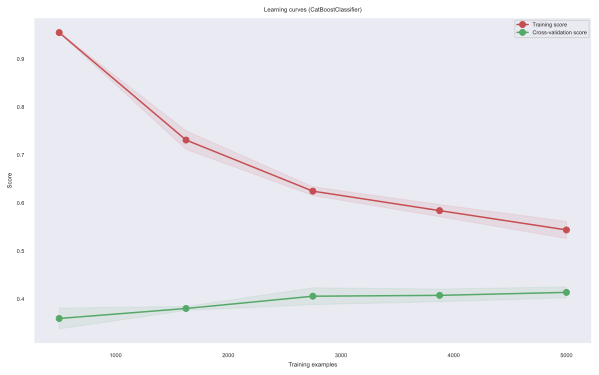

In [143]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса

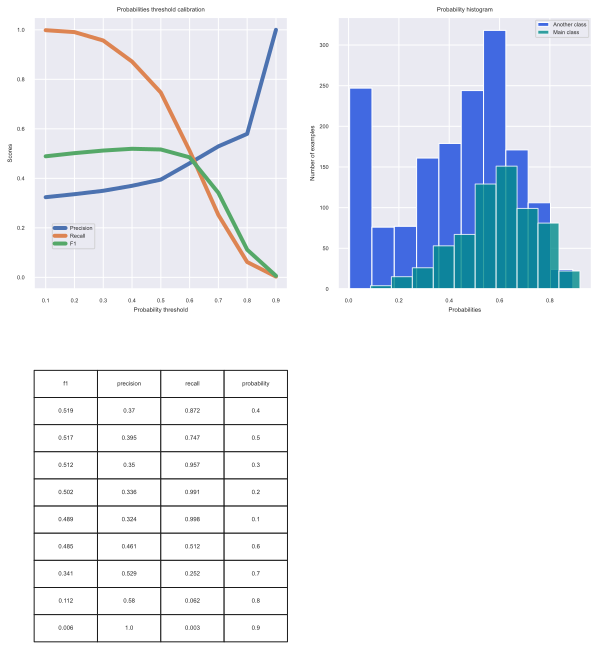

In [144]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

### Важность признаков

In [145]:
final_model.feature_importances_

array([4.96241128e+00, 2.00424357e-01, 2.67940118e+00, 3.96983797e+00,
       4.56078208e+00, 1.06383592e+00, 5.74759689e-02, 3.23855973e+01,
       2.68193502e+00, 3.06401619e+00, 6.15757200e+00, 6.40184137e-01,
       4.58181861e+00, 2.51070769e+01, 9.07433299e-02, 3.86861581e+00,
       4.97642043e-01, 3.19369183e-01, 3.65434214e-01, 6.94144559e-02,
       4.64660430e-02, 2.77840919e-01, 1.02589119e-01, 2.53656794e-01,
       0.00000000e+00, 1.54190321e-01, 3.63729077e-01, 2.06134889e-02,
       4.20870349e-01, 1.32427761e-01, 1.06031654e-01, 3.54701669e-01,
       0.00000000e+00, 7.97320679e-02, 1.90068908e-02, 1.41007709e-01,
       1.08039592e-03, 0.00000000e+00, 2.12594370e-03, 1.32696897e-01,
       6.76449700e-02, 0.00000000e+00, 0.00000000e+00])

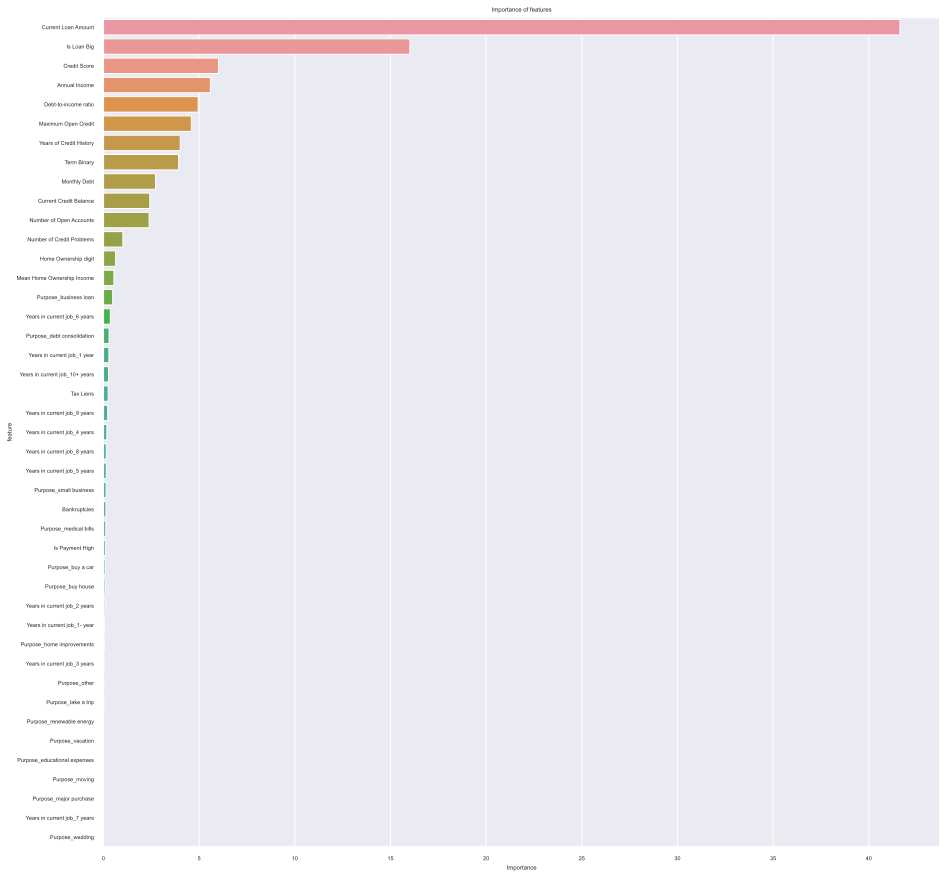

In [106]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [146]:
important_features_top

['Current Loan Amount',
 'Is Loan Big',
 'Credit Score',
 'Annual Income',
 'Debt-to-income ratio',
 'Maximum Open Credit',
 'Years of Credit History',
 'Term Binary',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Home Ownership digit',
 'Mean Home Ownership Income',
 'Purpose_business loan']

In [148]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, learning_rate=0.05, 
                                      l2_leaf_reg=10, class_weights=[1, 1.5],
                                      silent=True, random_state=27)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_valid_pred = final_model.predict(X_valid[important_features_top])
y_valid_pred_probs = final_model.predict_proba(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.58      0.69      3784
           1       0.62      0.87      0.72      2932

    accuracy                           0.71      6716
   macro avg       0.74      0.73      0.71      6716
weighted avg       0.75      0.71      0.71      6716

VALID

              precision    recall  f1-score   support

           0       0.84      0.54      0.66      1603
           1       0.40      0.75      0.52       647

    accuracy                           0.60      2250
   macro avg       0.62      0.64      0.59      2250
weighted avg       0.71      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               865  738
1               163  484
CPU times: user 4 s, sys: 518 ms, total: 4.52 s
Wall time: 2.5 s
